In [1]:
# Import libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Data preprocessing
data_dir = "C:/Users/user/Jupyter/fruit-veg-freshness-detector/data/processed/"

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_train)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_test)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

class_names = train_dataset.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Import and modify RESNET model
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)


C:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:03<00:00, 13.1MB/s]


In [4]:
# Loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [5]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")

        # Validation
        val_acc = evaluate_model(model, val_loader, device)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_resnet_model.pth')
            print(f"✅ Best model saved (val acc: {val_acc:.4f})")

    print("✅ Training complete.")

def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [6]:
# Metrics and confusion matrix
def evaluate_with_metrics(model, test_loader, class_names, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1-score: {f1:.4f}")
    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return y_true, y_pred

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Epoch 1/10 - Loss: 0.8280 - Acc: 0.7921
✅ Best model saved (val acc: 0.9065)
Epoch 2/10 - Loss: 0.3673 - Acc: 0.8959
✅ Best model saved (val acc: 0.9097)
Epoch 3/10 - Loss: 0.2969 - Acc: 0.9131
✅ Best model saved (val acc: 0.9202)
Epoch 4/10 - Loss: 0.2565 - Acc: 0.9225
✅ Best model saved (val acc: 0.9368)
Epoch 5/10 - Loss: 0.2356 - Acc: 0.9262
Epoch 6/10 - Loss: 0.2270 - Acc: 0.9276
Epoch 7/10 - Loss: 0.2089 - Acc: 0.9320
✅ Best model saved (val acc: 0.9384)
Epoch 8/10 - Loss: 0.1997 - Acc: 0.9363
✅ Best model saved (val acc: 0.9412)
Epoch 9/10 - Loss: 0.1930 - Acc: 0.9365
Epoch 10/10 - Loss: 0.1846 - Acc: 0.9399
✅ Best model saved (val acc: 0.9446)
✅ Training complete.
✅ Accuracy: 0.9392
✅ Precision: 0.9402
✅ Recall: 0.9392
✅ F1-score: 0.9388

📋 Classification Report:
                      precision    recall  f1-score   support

      Apple__Healthy       0.94      0.95      0.95       367
       Apple__Rotten       0.93      0.93      0.93       440
     Banana__Healthy       0.98

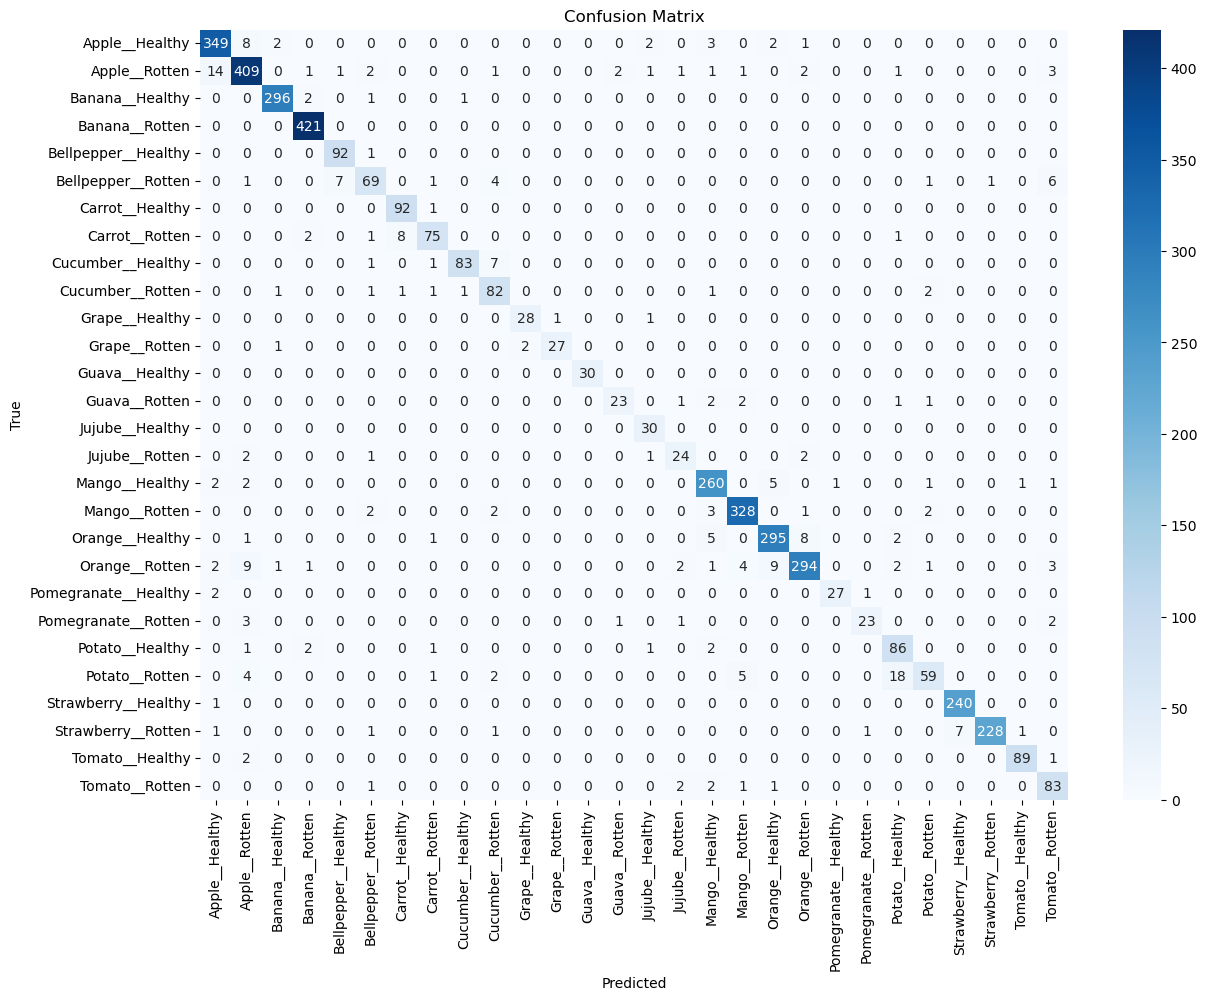

In [7]:
# Training and evaluation

train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

# Load best model
model.load_state_dict(torch.load('best_resnet_model.pth'))

# Final Test Evaluation
y_true, y_pred = evaluate_with_metrics(model, test_loader, class_names, device)
plot_confusion_matrix(y_true, y_pred, class_names)
